<a href="https://colab.research.google.com/github/Jeongrnin/Computer-vision/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 라이브러리

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

2. 모델 정의 (encoder)

In [18]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self) .__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3,padding=1),  # 16 x 28 x 28
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,padding=1),  # 32 x 28 x 28
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32,64,3,padding=1),  # 64 x 28 x 28
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2)              # 64 x 14 x 14
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64,128,3,padding=1), # 128 x 14 x 14
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128,256,3,padding=1), # 256 x 7 x 7
        nn.ReLU()
    )
  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1)
    return out

모델 정의 (decoder)

In [19]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(256,128,3,2,1,1), # 128 x 14 x 14
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128,64,3,1,1),    # 64 x 14 x 14
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(64,16,3,1,1),     # 16 x 14 x 14
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.ConvTranspose2d(16,1,3,2,1,1),    # 1 x 28 x 28
        nn.ReLU()
    )
  def forward(self,x):
    out = x.view(batch_size,256,7,7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

3. 데이터 로딩 & 데이터 로더

In [20]:
mnist_train = dset.MNIST("./data/MNIST", train=True,
    transform=transforms.ToTensor(), target_transform=None, download=True)

mnist_test = dset.MNIST("./data/MNIST", train=False,
    transform=transforms.ToTensor(), target_transform=None, download=True)

In [21]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(mnist_train,
    batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

test_loader = torch.utils.data.DataLoader(mnist_test,
    batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

4. 초기 설정

In [22]:
num_epoch = 10
learning_rate = 0.0002

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = itertools.chain(encoder.parameters(), decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

훈련 전에 test해보기

In [23]:
for i in range(1):
  for j,[image, label] in enumerate(test_loader):

    image = image.to(device)
    z = encoder(image)
    output = decoder(z)

    loss = loss_func(output,image)

#  if j % 10 == 0:
#      print(loss)
  print("loss is", loss.cpu().item())

loss is 0.8600968718528748


Test 결과 출력

torch.Size([100, 28, 28])


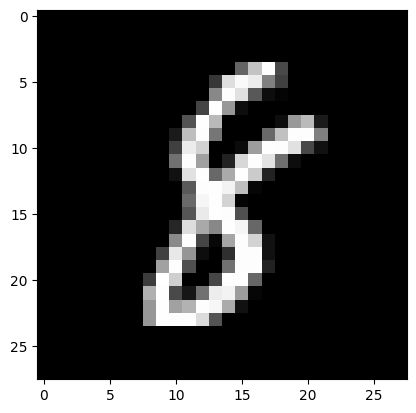

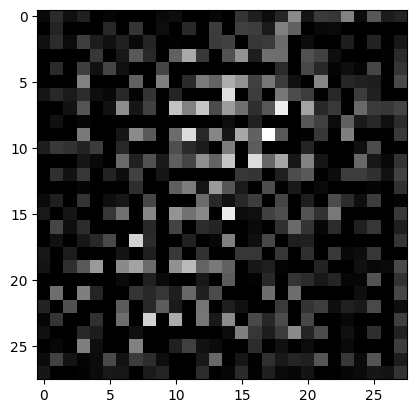

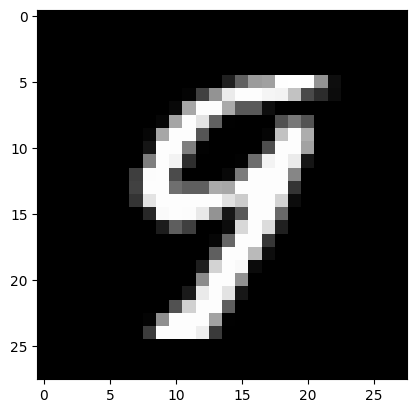

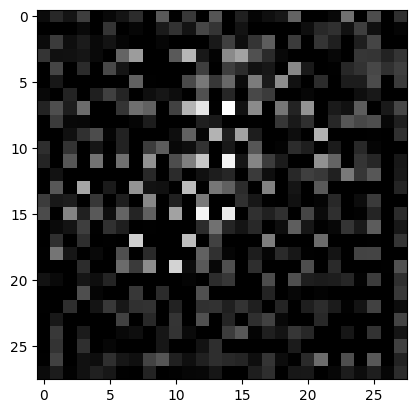

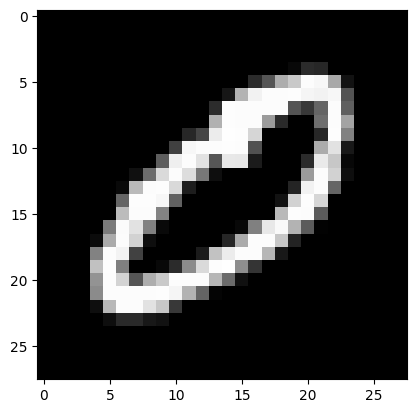

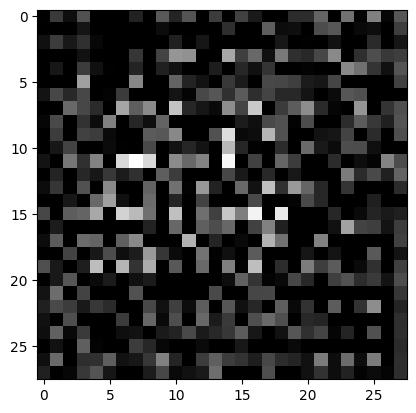

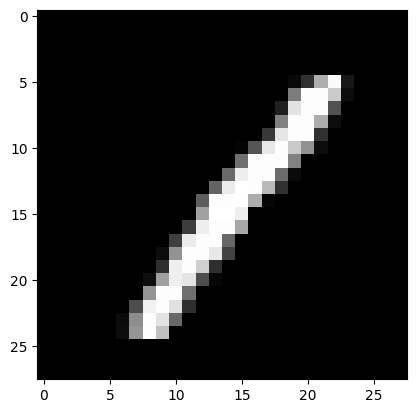

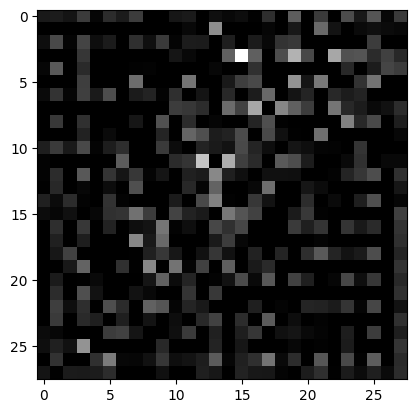

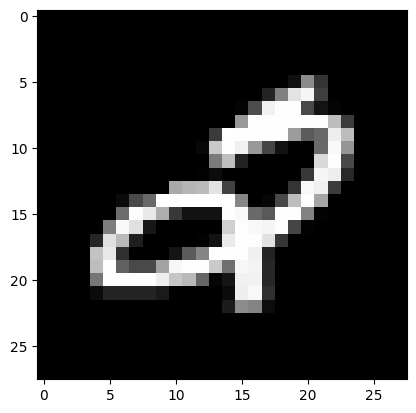

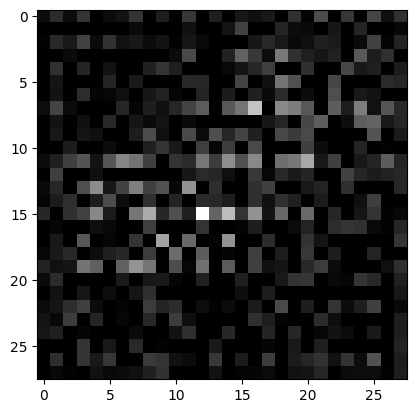

In [24]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()

5. 훈련

In [28]:
for i in range(num_epoch):
  for j,[image, label] in enumerate(train_loader):
    optimizer.zero_grad()

    image = image.to(device)
    z = encoder(image)
    output = decoder(z)
    loss = loss_func(output, image)

    loss.backward()
    optimizer.step()

  print("loss is", loss.cpu().item())

loss is 0.0008922939887270331
loss is 0.000868308765348047
loss is 0.0008125131716951728
loss is 0.0005958530236966908
loss is 0.0006443692254833877
loss is 0.0005533872172236443
loss is 0.0006369202747009695
loss is 0.000484259711811319
loss is 0.0004197309317532927
loss is 0.0004407392116263509


torch.Size([100, 28, 28])


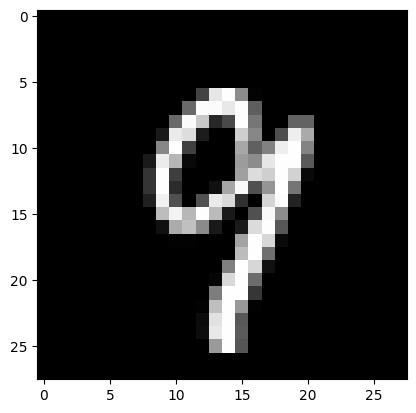

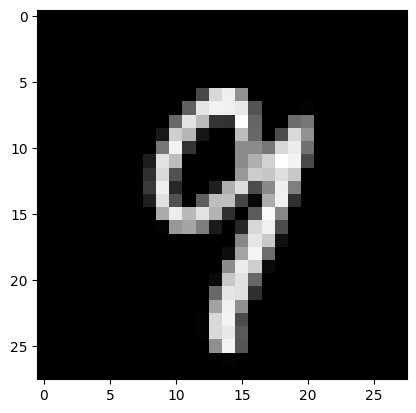

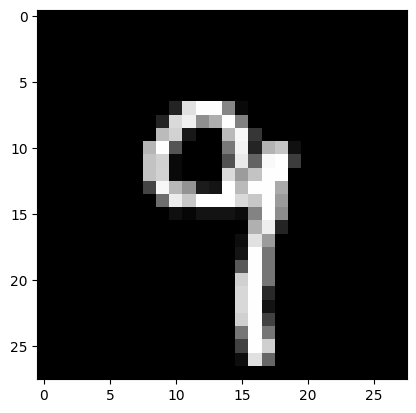

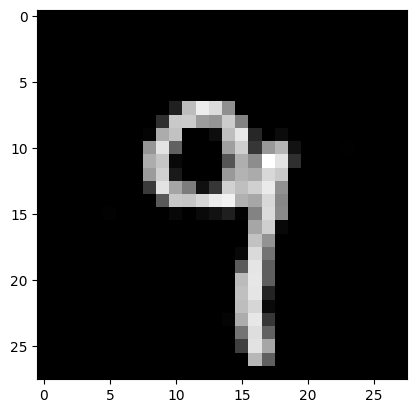

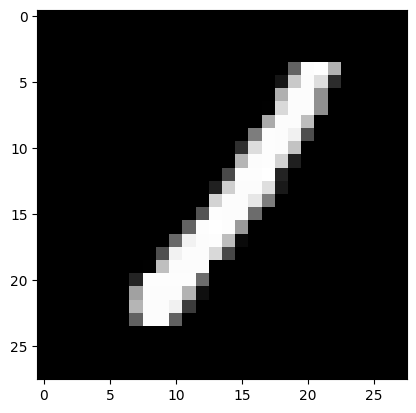

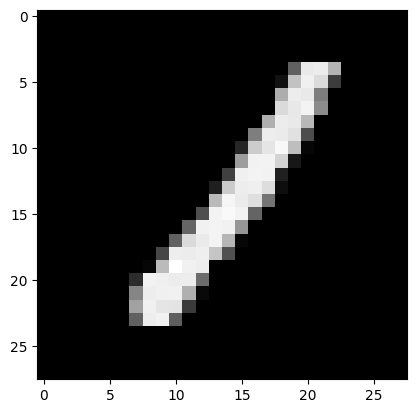

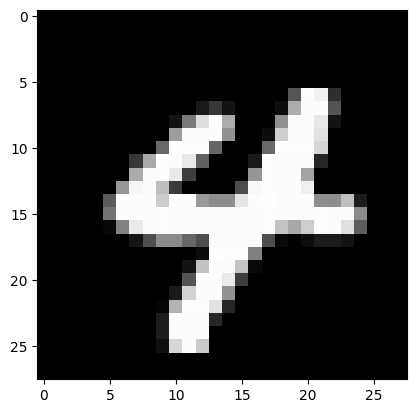

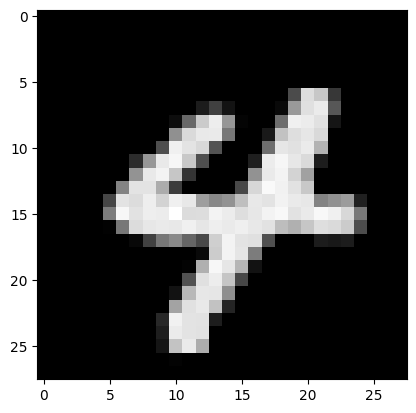

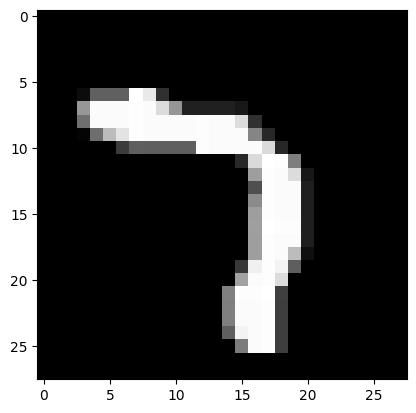

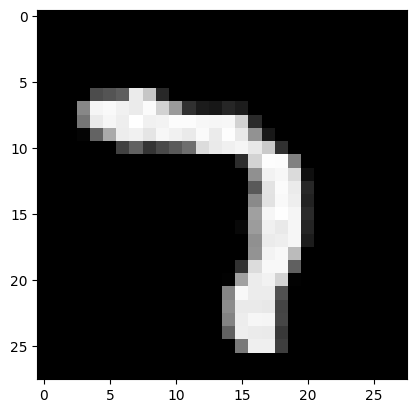

In [29]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
  plt.imshow(torch.squeeze(image[i].cpu()).data.numpy(),cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(),cmap='gray')
  plt.show()